In [1]:
import boto3
from IPython.display import Image, display
!pip install textract-trp
from trp import Document
from PIL import Image as PImage, ImageDraw
import time
from IPython.display import IFrame

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

## 1. Data Capture
Create Amazon S3 Bucket and upload document to your
S3 Bucket for Intelligent document Processing

In [5]:
# Create a Unique S3 bucket

s3BucketName = "mybucketbook12345"
print(s3BucketName)

mybucketbook12345


In [12]:
# Amazon S3 client

s3 = boto3.client('s3')

# Amazon Textract client
textract = boto3.client('textract')


In [9]:
# Upload document to your S3 Bucket

print(s3BucketName)
!aws s3api create-bucket --bucket {s3BucketName}
!aws s3 cp sync-densetext.png s3://{s3BucketName}/syncdensetext.png

mybucketbook12345
{
    "Location": "/mybucketbook12345"
}
upload: ./sync-densetext.png to s3://mybucketbook12345/syncdensetext.png


## Syncronous Extraction for document

In [10]:
chapter2_syncdensedoc = "syncdensetext.png"
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': chapter2_syncdensedoc})))

In [13]:
# Document Extraction with Amazon Textract

response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': chapter2_syncdensedoc
        }
    })


# Print All the lines
for line in response["Blocks"]:
    if line["BlockType"] == "LINE":
        print (line["Text"])

It was a Wednesday evening, and I was collecting all my receipts and busy filling out my
insurance claim document. I wanted to submit to my Health Insurance for reimbursement for
my COVID-19 test kits that I have purchased. The next day I went to the post office to send
documents through postal mail to my insurance provider. This made me think, in the 21 st
century we are still working with physical documents. With my approximate math this month
alone, we will get X number of documents per month considering 20% of entire US
population buys a test kit. This is a tons of documents as in this instance. In addition to
physical copies we have tons of documents which are might be just scanned documents. And
we are looking for manual processing for these number of documents. Can we do any better
in 21st century to automate the process of these documents?


## Asyncronous Document processing

In [14]:
def startasyncJob(s3BucketName, filename):
    response = None
    response = textract.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': filename
        }
    })

    return response["JobId"]

def isAsyncJobComplete(jobId):
    response = textract.get_document_text_detection(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(10)
        response = textract.get_document_text_detection(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def getAsyncJobResult(jobId):

    pages = []
    response = textract.get_document_text_detection(JobId=jobId)
    
    pages.append(response)
    ntoken = None
    if('NextToken' in response):
        ntoken = response['NextToken']

    while(ntoken):
        response = textract.get_document_text_detection(JobId=jobId, NextToken=ntoken)

        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            ntoken = response['NextToken']

    return pages

In [15]:
jobId = startasyncJob(s3BucketName, chapter2_syncdensedoc)
print("Started job with id: {}".format(jobId))
if(isAsyncJobComplete(jobId)):
    response = getAsyncJobResult(jobId)

# Print detected text
for resultPage in response:
    for item in resultPage["Blocks"]:
        if item["BlockType"] == "LINE":
            print ('\033[94m' +  item["Text"] + '\033[0m')

Started job with id: 475fc0e67fad0133779d96a658e042a6bc9ef0873b12d0363d3604e944156118
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
It was a Wednesday evening, and I was collecting all my receipts and busy filling out my
insurance claim document. I wanted to submit to my Health Insurance for reimbursement for
my COVID-19 test kits that I have purchased. The next day I went to the post office to send
documents through postal mail to my insurance provider. This made me think, in the 21 st
century we are still working with physical documents. With my approximate math this month
alone, we will get X number of documents per month considering 20% of entire US
population buys a test kit. This is a tons of documents as in this instance. In addition to
physical copies we have tons of documents which are might be just scanned documents. And
we are looking for manual processing for these number of documents. Can we do any better
in 21st century to automate the process of t

## Sensitive Document Processing. 
Document is stored in local file system. Want to process it Locally without storing in cloud. 

In [16]:
# Document Name
chapter2_sensitivedoc = "sensitive-doc.png"
print(chapter2_sensitivedoc)

sensitive-doc.png


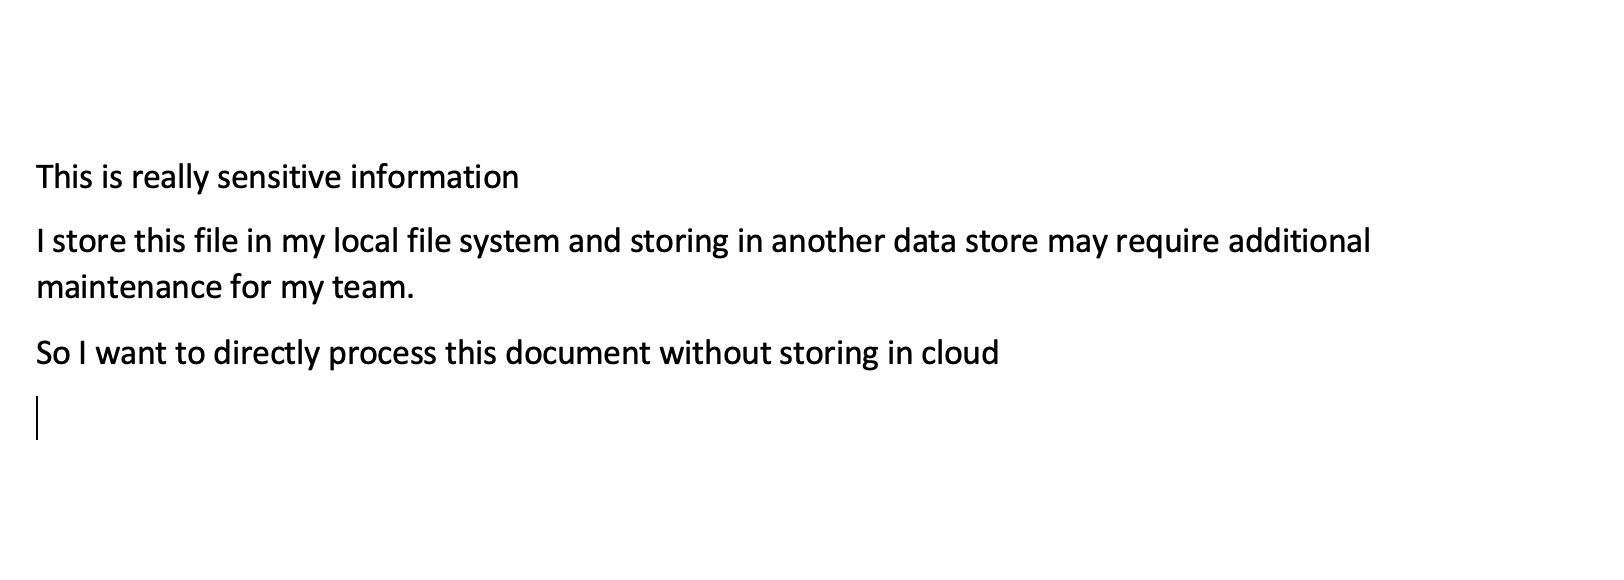

In [17]:
display(Image(filename=chapter2_sensitivedoc))

In [18]:
# Read sensitive document content
with open(chapter2_sensitivedoc, 'rb') as document:
    imgbytes = bytearray(document.read())

# Call Amazon Textract by sending bytes
res = textract.detect_document_text(Document={'Bytes': imgbytes})

# Print detected text
for line in res["Blocks"]:
    if line["BlockType"] == "LINE":
        print (line["Text"])

This is really sensitive information
I store this file in my local file system and storing in another data store may require additional
maintenance for my team.
So I want to directly process this document without storing in cloud


### End of Data Capture 